# Initialize

In [1]:
from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["highs", "gurobi"],  # modules to install
    license_uuid="1792fa9b-9f52-4d9d-8e9f-6742eb1b2c5a",  # license to use
)  # instantiate AMPL object and register magics

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#https://amplpy.ampl.com/en/latest/quick-start.html#load-model-and-data-from-files


Licensed to Bundle #6427.6818 expiring 20240531: CEE 4880: Applied Modeling and Simulation for Renewable Energy Systems, Jacob Mays, Cornell University.


In [2]:
import random
random.seed(10)

# Base model

In [3]:
%%writefile final_proj_base.mod

param nPeriods >= 1 default 8760;   

# Sets
set T = {1..nPeriods} ordered; #time
set G; #generator
set S; #storage
set N; #nuclear

# General parameters
#param length{T};
param demand{T};
param power_viol_penalty >= 0 default 10000;

# Generator parameters
param operating_cost{G};
param social_cost{G};
param invest_cost_g{G};
param availability{T,G} >=0, <=1, default 1;

# Storage parameters
param invest_cost_s{S};
param storage_init_charge{S}>=0, default 0;
param storage_duration{S}>= 0, default 4;
param discharge_coef{S}>=0, <=1, default .93;
param charge_coef{S}>=0, <=1, default .93;

#Nuclear parameters
param fixed_cost_n{N}; #existing nuclear fixed cost
param operating_cost_n{N}; #existing nuclear op cost
param capacity_n_existing{N}; #existing nuclear capacity

# Variables
var capacity_g{g in G} >= 0;
var capacity_s{s in S} >=0;
var capacity_n{n in N} >= 0; #how much existing nuclear to activate
var output_gt{g in G, t in T} >= 0;
var output_nt{n in N, t in T} >=0; #existing nuclear output per t
var discharge_st{s in S, t in T} >=0;
var charge_st{s in S, t in T} >=0;
var SOC_st{s in S, t in T} >=0;
var slack_t{t in T}>=0;
var surplus_t{t in T}>=0;

# Objective function
minimize total_cost:
    (sum{g in G, t in T} ((operating_cost[g]+social_cost[g])*output_gt[g,t]))+
    (sum{g in G} (invest_cost_g[g]*capacity_g[g]))+
    (sum{n in N}(fixed_cost_n[n]*capacity_n[n]))+
    (sum{n in N, t in T}(operating_cost_n[n]*output_nt[n,t]))+
    (sum{t in T} power_viol_penalty*(slack_t[t]+surplus_t[t]))+
    (sum{s in S} (invest_cost_s[s]*capacity_s[s]));
    
# Constraints

s.t. existing_nuclear_capacity{n in N}:
capacity_n[n]<=capacity_n_existing[n];

# generator availability
s.t. power_output{g in G, t in T}:
output_gt[g,t]<=availability[t,g]*capacity_g[g];

s.t. nuclear_output{n in N, t in T}:
output_nt[n,t]<=capacity_n[n];

# demand / system balance
s.t. meet_demand{t in T}:
#sum{g in G}(output_gt[g,t])+(sum{s in S}(discharge_st[s,t]-charge_st[s,t]))+slack_t-surplus_t[t]=demand_t[t];
(sum{g in G} output_gt[g,t]) +(sum{s in S} (discharge_st[s,t]-charge_st[s,t]))+(sum{n in N} output_nt[n,t])+slack_t[t]-surplus_t[t] = demand[t];

# max storage charge
s.t. max_charge{s in S, t in T}:
charge_st[s,t]<=capacity_s[s];

# max storage discharge
s.t. max_discharge{s in S, t in T}:
discharge_st[s,t]<=capacity_s[s];

# storage SOC consistency
s.t. battery_state_of_charge_first_instance{s in S, t in {first(T)}}:
SOC_st[s,t]-storage_init_charge[s]+discharge_st[s,t]/discharge_coef[s]-charge_coef[s]*charge_st[s,t]=0;

s.t. battery_state_of_charge{s in S, t in T diff{first(T)}}:
SOC_st[s,t]-SOC_st[s,t-1]+discharge_st[s,t]/discharge_coef[s]-charge_coef[s]*charge_st[s,t]=0;

s.t. max_storage_capacity{s in S, t in T}:
SOC_st[s,t]<=storage_duration[s]*capacity_s[s];

# exsiting capacities
s.t. current_capacity_solar{g in G}:
capacity_g['SOLAR']>=4400;

s.t. current_capacity_wind{g in G}:
capacity_g['WIND']>=2500;

Overwriting final_proj_base.mod


In [14]:
#cost of generator; data from NYISO-11-zone.csv, nuclear from 
gen_df = pd.DataFrame([("GAS",38.72,0.449*100,1237000), #898 pounds CO2e/MWh and $100/ton CO2e
                           ("WIND",0,0,1292000), 
                           ("SOLAR",0,0,1290000),
                           ("NUCLEAR",22.73,0,0), # investment cost = 0 because they are all existing
                           ("HYDRO",12.44,0,0)], # same as above
                            columns=["G", "operating_cost", "social_cost","invest_cost_g"],
                          ).set_index("G")
                            #operating cost($/mwh), social cost ($/mwh), capacity cost($/mw)
#old nulcear information
cost_N_df = pd.DataFrame([("OLD_NUCLEAR",10,0,150000),
                           ],
                            columns=["N", "operating_cost_n", "capacity_n_existing","fixed_cost_n"],
                          ).set_index("N")
    
#storage information
storage_df = pd.DataFrame([("FOUR", 0.93,0.93,4,0,400000),],
                            columns=["S", "discharge_coef", "charge_coef","storage_duration","storage_init_charge","invest_cost_s"],
                        ).set_index("S")

#availability
avail_df = pd.read_csv('./solar_wind_avail_2.csv').dropna()
avail_df.index = avail_df.index + 1

#demand
demand_df = pd.read_csv('./fixed_demand_2.csv').dropna()
demand_df.index = demand_df.index + 1

In [5]:
noise = np.random.normal(loc=0, scale=0.1, size=len(avail_df))
avail_df['HYDRO'] += noise
avail_df['HYDRO'] = np.clip(avail_df['HYDRO'], 0, 1)

In [6]:
def base_case(demand_df,avail_df):
    summary_df = pd.DataFrame(columns=['GAS',  'HYDRO','NUCLEAR', 'SOLAR', 'WIND','STORAGE', 'TOTAL_COST'])
    
    ampl = AMPL()
    solver = 'gurobi'
    ampl.set_option("solver", solver)
    ampl.read('final_proj_base.mod')

    # Define sets and parameters
    ampl.set_data(gen_df, "G")
    ampl.set_data(cost_N_df, "N")
    ampl.set_data(storage_df, "S")
    ampl.param['nPeriods'] = len(demand_df)
    ampl.param['power_viol_penalty'] = 10000
    ampl.param['demand'] = demand_df
    ampl.param['availability'] = avail_df
    capacity_g = ampl.get_variable("capacity_g")
    capacity_g['NUCLEAR'].fix(3400) #3.4 GW of nuclear
    capacity_g['HYDRO'].fix(6085) #6.085 GW of hydro
    
    ampl.solve()

    # Get resource mix
    resource_mix_list = np.array(ampl.get_variable("capacity_g").get_values().to_pandas()).flatten()

    # Get storage capacity
    storage_mix_list = np.array(ampl.get_variable("capacity_s").get_values().to_pandas()).flatten()

    # Get total cost
    total_cost_list = np.array(ampl.get_objective("total_cost").get_values().to_pandas()).flatten()

    # Create DataFrame for current iteration
    iteration_df = pd.DataFrame({
        'GAS': resource_mix_list[0],
        'HYDRO': resource_mix_list[1],
        'NUCLEAR': resource_mix_list[2],
        'SOLAR': resource_mix_list[3],
        'WIND': resource_mix_list[4],
        'STORAGE': storage_mix_list[0],
        'TOTAL_COST': total_cost_list[0]
    }, index=[0])

    summary_df = pd.concat([summary_df, iteration_df], ignore_index=True)
    sum_output = ampl.get_data("{g in G} sum {t in T} output_gt[g,t]").to_pandas()
    print(sum_output)
    return summary_df

In [118]:
 base_case_df = base_case(demand_df,avail_df)

Gurobi 11.0.1:Gurobi 11.0.1: optimal solution; objective 4.299183598e+10
51229 simplex iterations
42 barrier iterations

"option abs_boundtol 4.440892098500626e-16;"
or "option rel_boundtol 1.1104033160509338e-16;"
will change deduced dual values.

         sum{t in T} output_gt[g,t]
GAS                    9.159619e+07
HYDRO                  2.416322e+07
NUCLEAR                2.978400e+07
SOLAR                  5.237409e+06
WIND                   9.921819e+06


In [206]:
avail_df.describe()

,WIND,SOLAR,HYDRO
count,8760.000000,8760.000000,8760.000000
mean,0.453051,0.135881,0.453051
std,0.269249,0.191221,0.269249
min,0.001250,0.000000,0.001250
25%,0.232250,0.000000,0.232250
50%,0.405438,0.002545,0.405438
75%,0.662875,0.260932,0.662875
max,0.994875,0.758545,0.994875


In [119]:
base_case_df

,GAS,HYDRO,NUCLEAR,SOLAR,WIND,STORAGE,TOTAL_COST
0,18836.602909,6085.0,3400.0,4400.0,2500.0,3452.667193,4.299184e+10


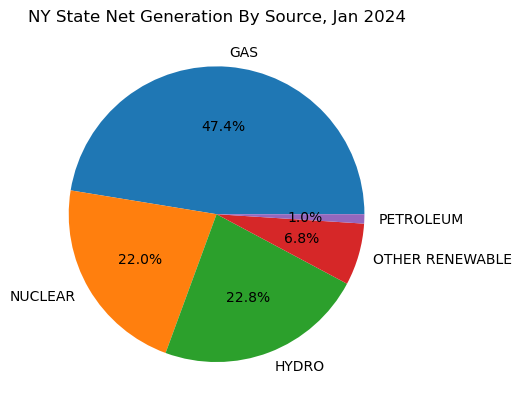

In [76]:
energy_sources = ['GAS', 'NUCLEAR', 'HYDRO', 'OTHER RENEWABLE','PETROLEUM']
energy_values = [5311, 2461, 2554, 759,114]

plt.pie(energy_values, labels=energy_sources, autopct='%1.1f%%')
plt.title('NY State Net Generation By Source, Jan 2024')
plt.show()

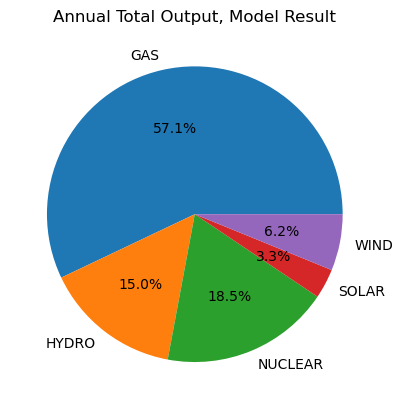

In [91]:
energy_sources = ['GAS', 'HYDRO', 'NUCLEAR', 'SOLAR', 'WIND']
energy_values = [9.180014e+07, 2.414765e+07, 2.978400e+07, 5.237409e+06, 9.921819e+06]

plt.pie(energy_values, labels=energy_sources, autopct='%1.1f%%')
plt.title('Annual Total Output, Model Result')
plt.show()

# Code in decarbonization scenario (`decarb_case`)

Added a parameter called `decarb_percent` and a constraint enforcing it.

In [30]:
%%writefile final_proj_decarb.mod

param nPeriods >= 1 default 8760;

# Sets
set T = {1..nPeriods} ordered; #time
#set Y; #years
set G; #generator
set S; #storage
set N; #nuclear

# General parameters
#param length{T};
param demand{T};
param power_viol_penalty >= 0 default 10000;
param decarb_percent >=0, <=1, default 1.0;
param num_years >=0, default 1;

# Generator parameters
param operating_cost{G};
param social_cost{G};
param invest_cost_g{G};
param availability{T,G} >=0, <=1, default 1;

# Storage parameters
param invest_cost_s{S};
param storage_init_charge{S}>=0, default 0;
param storage_duration{S}>= 0, default 4;
param discharge_coef{S}>=0, <=1, default .93;
param charge_coef{S}>=0, <=1, default .93;

#Nuclear parameters
param fixed_cost_n{N}; #existing nuclear fixed cost
param operating_cost_n{N}; #existing nuclear op cost
param capacity_n_existing{N}; #existing nuclear capacity

# Variables
var capacity_g{g in G} >= 0; 
var capacity_s{s in S} >=0;
var capacity_n{n in N} >= 0; #how much existing nuclear to activate
var output_gt{g in G, t in T} >= 0;
var output_nt{n in N, t in T} >=0; #existing nuclear output per t
var discharge_st{s in S, t in T} >=0;
var charge_st{s in S, t in T} >=0;
var SOC_st{s in S, t in T} >=0;
var slack_t{t in T}>=0;
var surplus_t{t in T}>=0;

# Objective function
minimize total_cost:
    (sum{g in G, t in T} ((operating_cost[g]+social_cost[g])*output_gt[g,t]))+
    (sum{g in G} (invest_cost_g[g]*capacity_g[g]))+
    (sum{n in N}(fixed_cost_n[n]*capacity_n[n]))+
    (sum{n in N, t in T}(operating_cost_n[n]*output_nt[n,t]))+
    (sum{t in T} power_viol_penalty*(slack_t[t]+surplus_t[t]))+
    (sum{s in S} (invest_cost_s[s]*capacity_s[s]));
    
# Constraints

# existing nuclear
s.t. existing_nuclear_capacity{n in N}:
capacity_n[n]<=capacity_n_existing[n];

# generator availability
s.t. power_output{g in G, t in T}:
output_gt[g,t]<=availability[t,g]*capacity_g[g];

s.t. nuclear_output{n in N, t in T}:
output_nt[n,t]<=capacity_n[n];

# demand / system balance
s.t. meet_demand{t in T}:
#sum{g in G}(output_gt[g,t])+(sum{s in S}(discharge_st[s,t]-charge_st[s,t]))+slack_t-surplus_t[t]=demand_t[t];
(sum{g in G} output_gt[g,t]) +(sum{s in S} (discharge_st[s,t]-charge_st[s,t]))+(sum{n in N} output_nt[n,t])+slack_t[t]-surplus_t[t] = demand[t];

# max storage charge
s.t. max_charge{s in S, t in T}:
charge_st[s,t]<=capacity_s[s];

# max storage discharge
s.t. max_discharge{s in S, t in T}:
discharge_st[s,t]<=capacity_s[s];

# storage SOC consistency
s.t. battery_state_of_charge_first_instance{s in S, t in {first(T)}}:
SOC_st[s,t]-storage_init_charge[s]+discharge_st[s,t]/discharge_coef[s]-charge_coef[s]*charge_st[s,t]=0;

s.t. battery_state_of_charge{s in S, t in T diff{first(T)}}:
SOC_st[s,t]-SOC_st[s,t-1]+discharge_st[s,t]/discharge_coef[s]-charge_coef[s]*charge_st[s,t]=0;

s.t. max_storage_capacity{s in S, t in T}:
SOC_st[s,t]<=storage_duration[s]*capacity_s[s];

# exsiting capacities
s.t. current_capacity_solar{g in G}:
capacity_g['SOLAR']>=4400;

s.t. current_capacity_wind{g in G}:
capacity_g['WIND']>=2500;

# decarbonization
# s.t. decarb{g in G}:
# decarb_percent <= sum{t in T}((output_gt['SOLAR',t]+output_gt['WIND',t])/(sum{t in T} output_gt[g,t]));

s.t. decarb:
    decarb_percent <= (capacity_g['WIND']+capacity_g['SOLAR']+capacity_g['HYDRO']+capacity_g['NUCLEAR'])/(sum{g in G} capacity_g[g])

Overwriting final_proj_decarb.mod


In [31]:
def decarb_case(demand_df,avail_df,goal):
    #summary_df = pd.DataFrame(columns=['GAS', 'NUCLEAR', 'SOLAR', 'WIND', 'STORAGE', 'TOTAL_COST'])

    ampl = AMPL()
    solver = 'gurobi'
    ampl.set_option("solver", solver)
    ampl.read('final_proj_decarb.mod')

    # Define sets and parameters
    ampl.set_data(gen_df, "G")
    ampl.set_data(cost_N_df, "N")
    ampl.set_data(storage_df, "S")
    ampl.param['nPeriods'] = len(demand_df)
    ampl.param['power_viol_penalty'] = 10000
    ampl.param['demand'] = demand_df
    ampl.param['availability'] = avail_df
    ampl.param['decarb_percent'] = goal / 100
    capacity_g = ampl.get_variable("capacity_g")
    capacity_g['NUCLEAR'].fix(3400) #3.4 GW of nuclear
    capacity_g['HYDRO'].fix(6085) #6.085 GW of hydro
    ampl.solve()

    # Get resource mix
    resource_mix_list = np.array(ampl.get_variable("capacity_g").get_values().to_pandas()).flatten()

    # Get storage capacity
    storage_mix_list = np.array(ampl.get_variable("capacity_s").get_values().to_pandas()).flatten()

    # Get total cost
    total_cost_list = np.array(ampl.get_objective("total_cost").get_values().to_pandas()).flatten()

    # Create DataFrame for current iteration
    summary_df = pd.DataFrame({
        'GAS': resource_mix_list[0],
        'HYDRO': resource_mix_list[1],
        'NUCLEAR': resource_mix_list[2],
        'SOLAR': resource_mix_list[3],
        'WIND': resource_mix_list[4],
        'STORAGE': storage_mix_list[0],
        'TOTAL_COST': total_cost_list[0]
    }, index=[0])

    sum_output = ampl.get_data("{g in G} sum {t in T} output_gt[g,t]").to_pandas()

    return summary_df, sum_output

# Code in growing demand

Assuming the current demand data is for 2020, I simply multiply 2020's demand by a growth rate every year and add a random noise.

$\text{Demand}_{2040, t}=\text{Demand}_{2020, t}*1.0078^{20}+\epsilon,\forall t$

where $\epsilon \sim \mathcal{N} (0,\frac{325}{20}=16.25)$

### and
 
# Code in noisy avaiability

$\text{Avail}_{2040, g, t}=\text{Avail}_{2020, g, t}+\epsilon \: \forall t, g$

where $\epsilon \sim \mathcal{N} (0,0.05)$ and $0 \le \text{Avail}_{g} \le 1 \: \forall g$

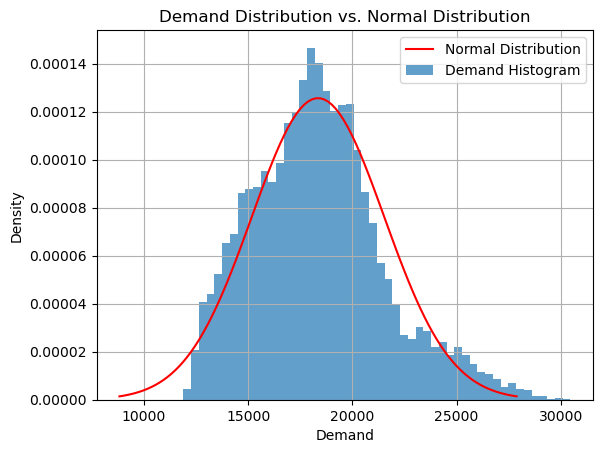

In [122]:
import warnings
from scipy.stats import shapiro, norm, kstest

warnings.filterwarnings("ignore")
demand_data = demand_df.to_numpy()
plt.hist(demand_data, bins=50, density=True, alpha=0.7, label='Demand Histogram')

# Plot normal distribution curve with mean and standard deviation from demand data
mu, sigma = np.mean(demand_data), np.std(demand_data)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, norm.pdf(x, mu, sigma), 'r-', label='Normal Distribution')

# Set labels and title
plt.xlabel('Demand')
plt.ylabel('Density')
plt.title('Demand Distribution vs. Normal Distribution')

# Add legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [12]:
def add_noise(data, mean=0, std=0.05):
    noise = np.random.normal(mean, std, data.shape)
    noisy_data = data + noise
    noisy_data[noisy_data < 0] = 0
    noisy_data[noisy_data > 1] = 1
    return noisy_data

avail_2040 = add_noise(avail_df)
demand_2040=demand_df*1.0078**20+np.random.normal(0, 16.25)

demand_2030 = demand_df*1.0078**10 + np.random.normal(0, 325/20)
avail_2030 = add_noise(avail_df)

# Viz functions defined

In [21]:
def graph_pie_installed_capacity(base_90_percent_summary,title):
    energy_sources = base_90_percent_summary.columns[:-1]
    energy_values = base_90_percent_summary.iloc[0][:-1].values
    
    plt.pie(energy_values, labels=base_90_percent_summary.columns[:-1], autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
    plt.show()
    base_90_percent_summary

In [22]:
def graph_pie_sum_output(base_90_percent_sum_output,title):
    energy_sources = base_90_percent_sum_output.index.tolist()
    energy_values = base_90_percent_sum_output['sum{t in T} output_gt[g,t]']
    
    plt.pie(energy_values, labels=energy_sources, autopct='%1.1f%%',startangle=140)
    plt.title(title)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
    plt.show()
    
    base_90_percent_sum_output

def graph_pie_sum_output_far(base_90_percent_sum_output,title,dist):
    energy_sources = base_90_percent_sum_output.index.tolist()
    energy_values = base_90_percent_sum_output['sum{t in T} output_gt[g,t]']
    
    plt.pie(energy_values, labels=energy_sources, autopct='%1.1f%%',startangle=140,pctdistance=dist)
    plt.title(title)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
    plt.show()
    
    base_90_percent_sum_output

In [159]:
def graph_stacked_bar(df,xlabel, title):
    energy_sources = df.drop(columns='TOTAL_COST').columns.tolist()#[ 'GAS', 'HYDRO', 'NUCLEAR', 'SOLAR', 'WIND', 'STORAGE']
    r = np.arange(len(df))
    bottom_series = np.zeros(len(df))

    for i, source in enumerate(energy_sources):
        values = df[source].tolist()
        bars = plt.bar(r, values, bottom=bottom_series, width=0.5, label=source)
        bottom_series += values
        
        # Add absolute value for storage
        if source == 'STORAGE':
            for bar, value in zip(bars, values):
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width() / 2.0, bar.get_y() + height / 2.0,
                         '{0:.0f} MW'.format(value), ha='center', va='center',fontsize=8)
                
        # Add percentage text on each bar
        if source != 'STORAGE':
            for bar, value in zip(bars, values):
                height = bar.get_height()
                total = df[energy_sources[:-1]].sum(axis=1).iloc[i]  # calculate the total for each row excluding 'STORAGE'
                plt.text(bar.get_x() + bar.get_width() / 2.0, bar.get_y() + height / 2.0,
                         '{0:.0%}'.format(value/total), ha='center', va='center',fontsize=8)

    plt.xlabel(xlabel)
    handles, labels = plt.gca().get_legend_handles_labels()
    labels.append('Total Cost')
    handles.append(plt.Line2D([], [], color='black', marker='x'))
    plt.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.1,1), ncol=1)
    plt.ylabel('Optimal Installed Capacity (MW)')
    ax2 = plt.gca().twinx()
    ax2.set_ylabel('10 billion $')
    ax2.plot(r, df['TOTAL_COST'].tolist(),color='black',marker='x')#, label='Total Cost'
    plt.xticks(r, invest_costs)
    plt.title(title,y=1.05)
    
    plt.show()

# Try `decarb_percent` = 0.9 with today's demand

In [176]:
base_90_percent_summary, base_90_percent_sum_output = decarb_case(demand_df,avail_df,90)

Gurobi 11.0.1:Gurobi 11.0.1: optimal solution; objective 9.74029941e+10
48470 simplex iterations
1 branching node
absmipgap=0.00190735, relmipgap=1.9582e-14


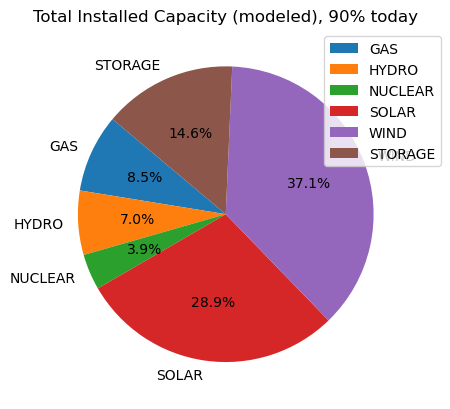

In [283]:
graph_pie_installed_capacity(base_90_percent_summary,'Total Installed Capacity (modeled), 90% today')

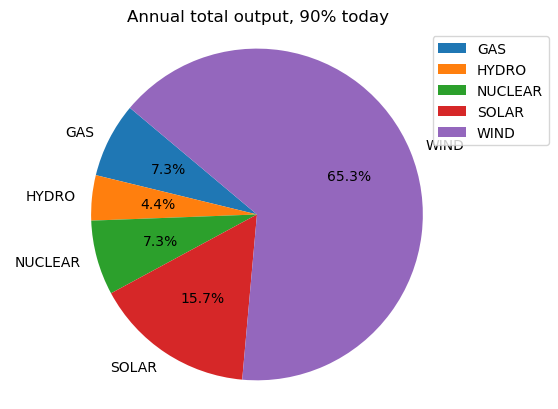

In [285]:
graph_pie_sum_output(base_90_percent_sum_output,'Annual total output, 90% today')

In [ ]:
base_90_percent #o

# Iterate over decarb scenario

## Function version

### Iterate `decarb_percent` over 0, 0.2, 0.4, 0.6, 0.8, 1.0, using `demand_2040` and `avail_2040`:

In [15]:
def different_decarb_goals():
    # Define an empty DataFrame to store results
    summary_df = pd.DataFrame(columns=['GAS', 'NUCLEAR', 'SOLAR', 'WIND', 'STORAGE', 'TOTAL_COST'])
    
    # Iterate over a decarb goal of 0, 0.1, ..., 1.0
    for decarb_ratio in range(0, 110, 10):
        # Initialize AMPL instance
        ampl = AMPL()
        solver = 'gurobi'
        ampl.set_option("solver", solver)
        ampl.read('final_proj_decarb.mod')

        # Define sets and parameters
        ampl.set_data(gen_df, "G")
        ampl.set_data(cost_N_df, "N")
        ampl.set_data(storage_df, "S")
        ampl.param['nPeriods'] = len(demand_2040)
        ampl.param['power_viol_penalty'] = 10000
        ampl.param['demand'] = demand_2040
        ampl.param['availability'] = avail_2040
        ampl.param['decarb_percent'] = decarb_ratio / 100
        capacity_g = ampl.get_variable("capacity_g")
        capacity_g['NUCLEAR'].fix(3400) #3.4 GW of nuclear
        capacity_g['HYDRO'].fix(6085) #6.085 GW of hydro
        # if decarb_ratio == 100:
        #     capacity_g = ampl.get_variable("capacity_g")
        #     capacity_g['NUCLEAR'].unfix()
        #     capacity_g['HYDRO'].unfix()
        ampl.solve()

        # Get resource mix
        resource_mix_list = np.array(ampl.get_variable("capacity_g").get_values().to_pandas()).flatten()
        
        # Get storage capacity
        storage_mix_list = np.array(ampl.get_variable("capacity_s").get_values().to_pandas()).flatten()
        
        # Get total cost
        total_cost_list = np.array(ampl.get_objective("total_cost").get_values().to_pandas()).flatten()

        # Create DataFrame for current iteration
        iteration_df = pd.DataFrame({
            'GAS': resource_mix_list[0],
            'NUCLEAR': resource_mix_list[1],
            'SOLAR': resource_mix_list[2],
            'WIND': resource_mix_list[3],
            'STORAGE': storage_mix_list[0],
            'TOTAL_COST': total_cost_list[0]
        }, index=[0])

        # Concatenate iteration DataFrame to summary DataFrame
        summary_df = pd.concat([summary_df, iteration_df], ignore_index=True)

    return summary_df

## Non-function version

In [181]:
summary_df = pd.DataFrame(columns=['GAS', 'HYDRO','NUCLEAR', 'SOLAR', 'WIND', 'STORAGE', 'TOTAL_COST'])

# Iterate over a decarb goal of 0, 0.1, ..., 1.0
for decarb_ratio in range(0, 110, 10):
    # Initialize AMPL instance
    ampl = AMPL()
    solver = 'gurobi'
    ampl.set_option("solver", solver)
    ampl.read('final_proj_decarb.mod')

    # Define sets and parameters
    ampl.set_data(gen_df, "G")
    ampl.set_data(cost_N_df, "N")
    ampl.set_data(storage_df, "S")
    ampl.param['nPeriods'] = len(demand_2040)
    ampl.param['power_viol_penalty'] = 10000
    ampl.param['demand'] = demand_2040
    ampl.param['availability'] = avail_2040
    ampl.param['decarb_percent'] = decarb_ratio / 100
    capacity_g = ampl.get_variable("capacity_g")
    capacity_g['NUCLEAR'].fix(3400) #3.4 GW of nuclear
    capacity_g['HYDRO'].fix(6085) #6.085 GW of hydro
    # if decarb_ratio == 100:
    #     capacity_g = ampl.get_variable("capacity_g")
    #     capacity_g['NUCLEAR'].unfix()
    #     capacity_g['HYDRO'].unfix()
    ampl.solve()

    # Get resource mix
    resource_mix_list = np.array(ampl.get_variable("capacity_g").get_values().to_pandas()).flatten()
    
    # Get storage capacity
    storage_mix_list = np.array(ampl.get_variable("capacity_s").get_values().to_pandas()).flatten()
    
    # Get total cost
    total_cost_list = np.array(ampl.get_objective("total_cost").get_values().to_pandas()).flatten()

    # Create DataFrame for current iteration
    iteration_df = pd.DataFrame({
        'GAS': resource_mix_list[0],
        'HYDRO': resource_mix_list[1],
        'NUCLEAR': resource_mix_list[2],
        'SOLAR': resource_mix_list[3],
        'WIND': resource_mix_list[4],
        'STORAGE': storage_mix_list[0],
        'TOTAL_COST': total_cost_list[0]
    }, index=[0])

    # Concatenate iteration DataFrame to summary DataFrame
    summary_df = pd.concat([summary_df, iteration_df], ignore_index=True)

Gurobi 11.0.1:Gurobi 11.0.1: optimal solution; objective 5.063584754e+10
55731 simplex iterations
1 branching node
Gurobi 11.0.1:   NLP heuristic elapsed time = 5.02s
Gurobi 11.0.1: optimal solution; objective 5.063584754e+10
55125 simplex iterations
1 branching node
Gurobi 11.0.1:   NLP heuristic elapsed time = 5.02s
Gurobi 11.0.1: optimal solution; objective 5.063584754e+10
55125 simplex iterations
1 branching node
Gurobi 11.0.1:Gurobi 11.0.1: optimal solution; objective 5.063584754e+10
55125 simplex iterations
1 branching node
Gurobi 11.0.1:   NLP heuristic elapsed time = 5.00s
Gurobi 11.0.1: optimal solution; objective 5.063584754e+10
55125 simplex iterations
1 branching node
Gurobi 11.0.1:Gurobi 11.0.1: optimal solution; objective 5.417157448e+10
53413 simplex iterations
1 branching node
absmipgap=0.0562439, relmipgap=1.03825e-12
Gurobi 11.0.1:Gurobi 11.0.1: optimal solution; objective 6.06731624e+10
49071 simplex iterations
1 branching node
absmipgap=0.0235901, relmipgap=3.888

In [ ]:
summary_df = different_decarb_goals()

In [186]:
summary_df.to_csv('./2040_decarb_goal_NEW.csv')

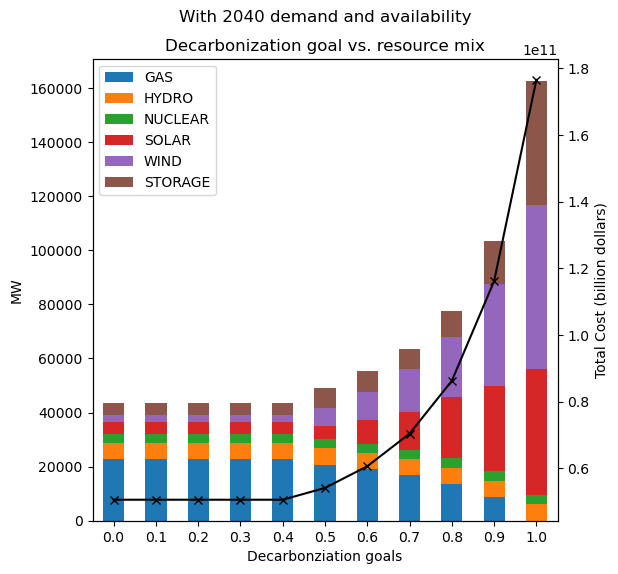

In [184]:
ax = summary_df[['GAS', 'HYDRO','NUCLEAR', 'SOLAR', 'WIND', 'STORAGE']].plot(kind='bar', stacked=True, figsize=(6, 6))
summary_df['TOTAL_COST'].plot(kind='line', marker='x', color='k', secondary_y=True,ax=ax)

ax.set_xlabel('Decarbonziation goals')
ax.set_ylabel('MW')
ax.right_ax.set_ylabel('Total Cost (billion dollars)')

plt.title('Decarbonization goal vs. resource mix')
plt.text(0.5, 1.08, 'With 2040 demand and availability', horizontalalignment='center', fontsize=12, transform=plt.gca().transAxes)
decarb_goals = [str(i/10) for i in range(11)]
plt.xticks(range(11), decarb_goals)
plt.show()

# Sensitivity analysis

### 1. 70 by 2030

In [24]:
decarb_70_by_2030_summary, decarb_70_by_2030_sum_output = decarb_case(demand_2030,avail_2030,70)

Gurobi 11.0.1:Gurobi 11.0.1: optimal solution; objective 6.403520567e+10
60741 simplex iterations
1 branching node
absmipgap=0.028862, relmipgap=4.50721e-13


In [32]:
decarb_70_by_2030_summary

,GAS,HYDRO,NUCLEAR,SOLAR,WIND,STORAGE,TOTAL_COST
0,15324.792095,6085.0,3400.0,13303.999361,12968.848861,6929.039201,6.403521e+10


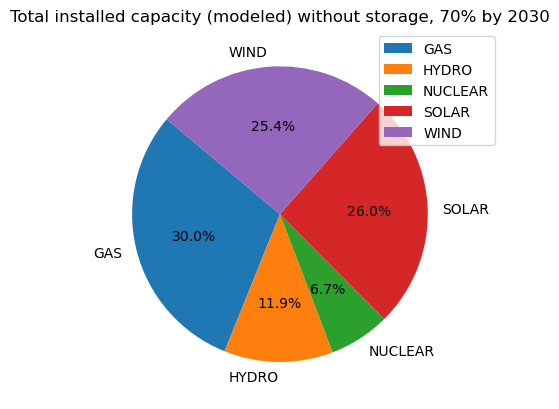

In [26]:
graph_pie_installed_capacity(decarb_70_by_2030_summary.drop(columns=['STORAGE']), 'Total installed capacity (modeled) without storage, 70% by 2030')

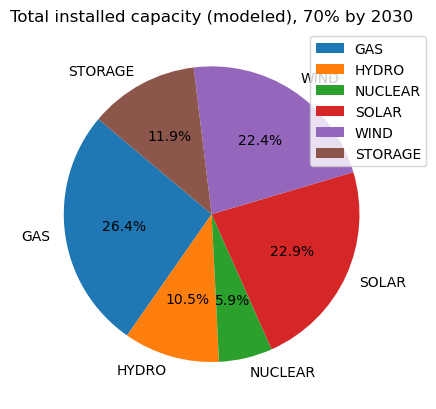

In [33]:
graph_pie_installed_capacity(decarb_70_by_2030_summary, 'Total installed capacity (modeled), 70% by 2030')

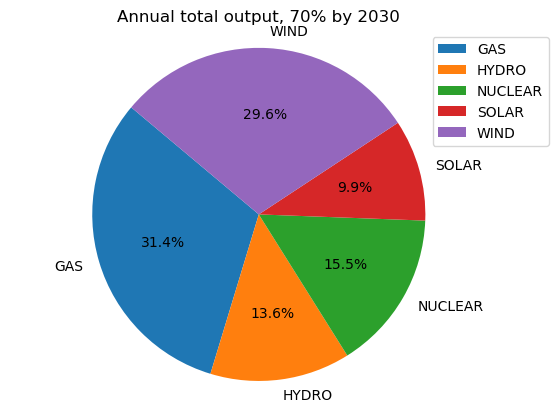

In [34]:
graph_pie_sum_output(decarb_70_by_2030_sum_output,'Annual total output, 70% by 2030')

### 2. 100 by 2040

In [35]:
decarb_100_by_2040_summary, decarb_100_by_2040_sum_output = decarb_case(demand_2040,avail_2040,100)

Gurobi 11.0.1:Gurobi 11.0.1: optimal solution; objective 1.766522128e+11
33551 simplex iterations
1 branching node


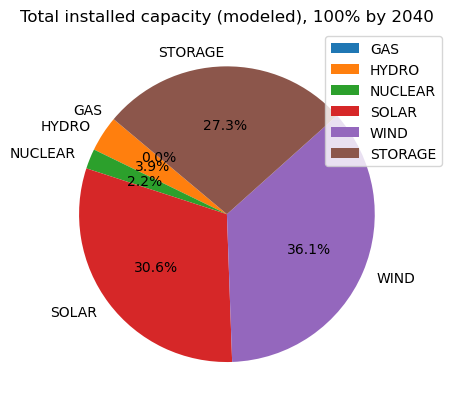

In [37]:
graph_pie_installed_capacity(decarb_100_by_2040_summary, 'Total installed capacity (modeled), 100% by 2040')

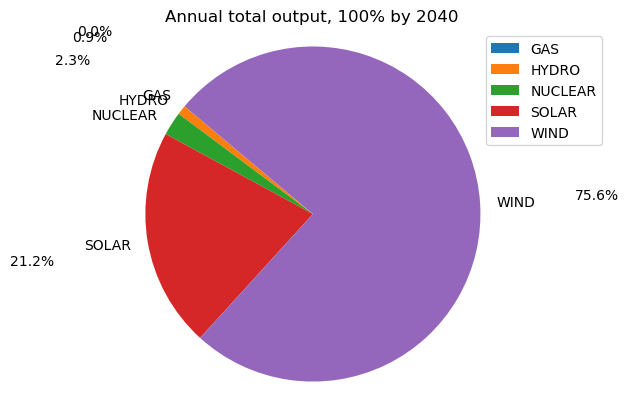

In [38]:
graph_pie_sum_output_far(decarb_100_by_2040_sum_output,'Annual total output, 100% by 2040',1.7)

### 3. Sensitivity: battery price

Uses 2030 demand and avail, and 70% as target

In [141]:
common_values = ["FOUR", 0.93, 0.93, 4, 0]

invest_costs = [200000, 400000, 600000, 800000, 1000000]

df_names = [pd.DataFrame([common_values + [cost]], 
                         columns=["S", "discharge_coef", "charge_coef", "storage_duration", "storage_init_charge", "invest_cost_s"]).set_index("S") 
            for cost in invest_costs]

In [142]:
#70 by 2030
summary_df_sa_bat = pd.DataFrame(columns=['GAS', 'HYDRO','NUCLEAR', 'SOLAR', 'WIND', 'STORAGE', 'TOTAL_COST'])

for i in range(len(df_names)):
    ampl = AMPL()
    solver = 'gurobi'
    ampl.set_option("solver", solver)
    ampl.read('final_proj_decarb.mod')

    # Define sets and parameters
    ampl.set_data(gen_df, "G")
    ampl.set_data(cost_N_df, "N")
    ampl.set_data(df_names[i], "S")
    ampl.param['nPeriods'] = len(demand_2030)
    ampl.param['power_viol_penalty'] = 10000
    ampl.param['demand'] = demand_2030
    ampl.param['availability'] = avail_2030
    ampl.param['decarb_percent'] = 0.7
    capacity_g = ampl.get_variable("capacity_g")
    capacity_g['NUCLEAR'].fix(3400) #3.4 GW of nuclear
    capacity_g['HYDRO'].fix(6085) #6.085 GW of hydro
    ampl.solve()

    # Get resource mix
    resource_mix_list = np.array(ampl.get_variable("capacity_g").get_values().to_pandas()).flatten()

    # Get storage capacity
    storage_mix_list = np.array(ampl.get_variable("capacity_s").get_values().to_pandas()).flatten()

    # Get total cost
    total_cost_list = np.array(ampl.get_objective("total_cost").get_values().to_pandas()).flatten()

    # Create DataFrame for current iteration
    iteration_df = pd.DataFrame({
        'GAS': resource_mix_list[0],
        'HYDRO': resource_mix_list[1],
        'NUCLEAR': resource_mix_list[2],
        'SOLAR': resource_mix_list[3],
        'WIND': resource_mix_list[4],
        'STORAGE': storage_mix_list[0],
        'TOTAL_COST': total_cost_list[0]
    }, index=[0])

    # Concatenate iteration DataFrame to summary DataFrame
    summary_df_sa_bat = pd.concat([summary_df_sa_bat, iteration_df], ignore_index=True)

Gurobi 11.0.1:Gurobi 11.0.1: optimal solution; objective 6.230392859e+10
53281 simplex iterations
1 branching node
absmipgap=0.00753021, relmipgap=1.20863e-13
Gurobi 11.0.1:Gurobi 11.0.1: optimal solution; objective 6.403520567e+10
60741 simplex iterations
1 branching node
absmipgap=0.028862, relmipgap=4.50721e-13
Gurobi 11.0.1:Gurobi 11.0.1: optimal solution; objective 6.516211475e+10
56874 simplex iterations
1 branching node
absmipgap=0.0117874, relmipgap=1.80894e-13
Gurobi 11.0.1:Gurobi 11.0.1: optimal solution; objective 6.602212084e+10
56351 simplex iterations
1 branching node
absmipgap=0.0107574, relmipgap=1.62937e-13
Gurobi 11.0.1:Gurobi 11.0.1: optimal solution; objective 6.669820426e+10
74892 simplex iterations
1 branching node
absmipgap=0.0197601, relmipgap=2.96262e-13


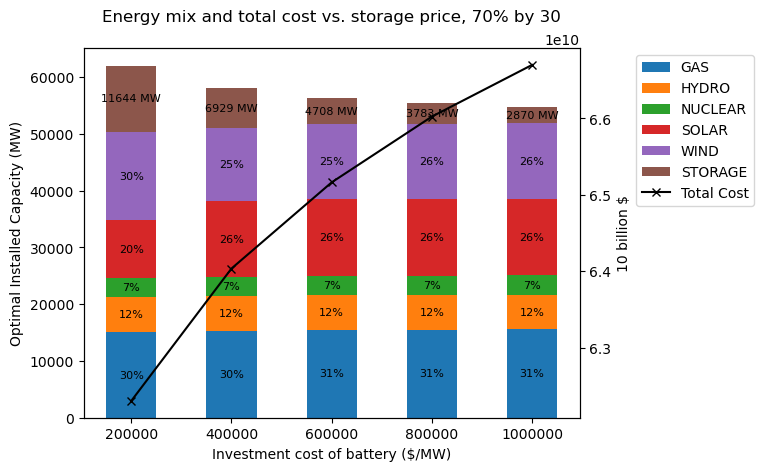

In [160]:
invest_costs = [200000, 400000, 600000, 800000, 1000000]
graph_stacked_bar(summary_df_sa_bat, "Investment cost of battery ($/MW)","Energy mix and total cost vs. storage price, 70% by 30")

In [48]:
summary_df_sa_bat.to_csv('./summary_df_sa_bat_nuclear')

In [144]:
common_values = ["FOUR", 0.93, 0.93, 4, 0]

invest_costs = [200000, 400000, 600000, 800000, 1000000]

df_names = [pd.DataFrame([common_values + [cost]], 
                         columns=["S", "discharge_coef", "charge_coef", "storage_duration", "storage_init_charge", "invest_cost_s"]).set_index("S") 
            for cost in invest_costs]

In [145]:
summary_df_sa_bat_100_by_2040 = pd.DataFrame(columns=['GAS', 'HYDRO','NUCLEAR', 'SOLAR', 'WIND', 'STORAGE', 'TOTAL_COST'])

for i in range(len(df_names)):
    ampl = AMPL()
    solver = 'gurobi'
    ampl.set_option("solver", solver)
    ampl.read('final_proj_decarb.mod')

    # Define sets and parameters
    ampl.set_data(gen_df, "G")
    ampl.set_data(cost_N_df, "N")
    ampl.set_data(df_names[i], "S")
    ampl.param['nPeriods'] = len(demand_2040)
    ampl.param['power_viol_penalty'] = 10000
    ampl.param['demand'] = demand_2040
    ampl.param['availability'] = avail_2040
    ampl.param['decarb_percent'] = 1.0
    capacity_g = ampl.get_variable("capacity_g")
    capacity_g['NUCLEAR'].fix(3400) #3.4 GW of nuclear
    capacity_g['HYDRO'].fix(6085) #6.085 GW of hydro
    ampl.solve()

    # Get resource mix
    resource_mix_list = np.array(ampl.get_variable("capacity_g").get_values().to_pandas()).flatten()

    # Get storage capacity
    storage_mix_list = np.array(ampl.get_variable("capacity_s").get_values().to_pandas()).flatten()

    # Get total cost
    total_cost_list = np.array(ampl.get_objective("total_cost").get_values().to_pandas()).flatten()

    # Create DataFrame for current iteration
    iteration_df = pd.DataFrame({
        'GAS': resource_mix_list[0],
        'HYDRO': resource_mix_list[1],
        'NUCLEAR': resource_mix_list[2],
        'SOLAR': resource_mix_list[3],
        'WIND': resource_mix_list[4],
        'STORAGE': storage_mix_list[0],
        'TOTAL_COST': total_cost_list[0]
    }, index=[0])

    # Concatenate iteration DataFrame to summary DataFrame
    summary_df_sa_bat_100_by_2040 = pd.concat([summary_df_sa_bat_100_by_2040, iteration_df], ignore_index=True)
    

Gurobi 11.0.1:Gurobi 11.0.1: optimal solution; objective 1.645357826e+11
32050 simplex iterations
1 branching node
Gurobi 11.0.1:Gurobi 11.0.1: optimal solution; objective 1.766522128e+11
33551 simplex iterations
1 branching node
Gurobi 11.0.1:Gurobi 11.0.1: optimal solution; objective 1.842153281e+11
36422 simplex iterations
1 branching node
absmipgap=0.0062561, relmipgap=3.39608e-14
Gurobi 11.0.1:   NLP heuristic elapsed time = 5.04s
Gurobi 11.0.1: optimal solution; objective 1.895190278e+11
34898 simplex iterations
1 branching node
Gurobi 11.0.1:Gurobi 11.0.1: optimal solution; objective 1.934666155e+11
35157 simplex iterations
1 branching node
absmipgap=0.00592041, relmipgap=3.06017e-14


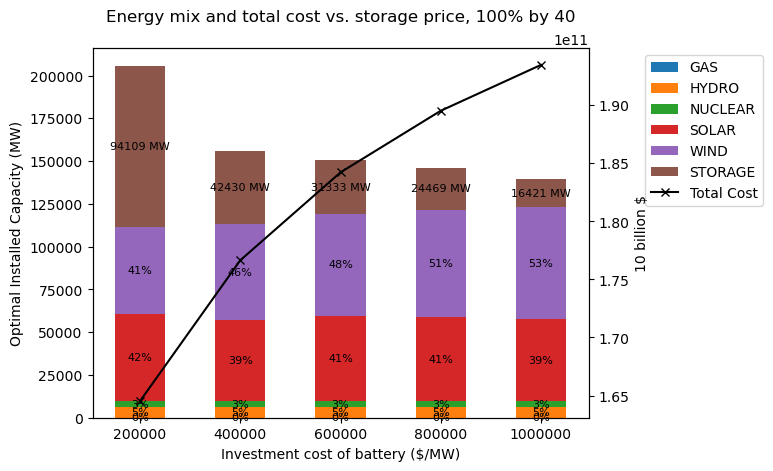

In [161]:
invest_costs = [200000, 400000, 600000, 800000, 1000000]
graph_stacked_bar(summary_df_sa_bat_100_by_2040, "Investment cost of battery ($/MW)","Energy mix and total cost vs. storage price, 100% by 40")

### 4. Sensitivity: renewable investment cost

In [40]:
common_values = [("GAS",38.72,44.9,1237000),
                 ("WIND",0,0,None),  # None will be replaced by the actual value in the loop
                 ("SOLAR",0,0,None),  # None will be replaced by the actual value in the loop
                 ("NUCLEAR",22.73,0,0),
                ("HYDRO", 12.44,0,0)]

invest_costs = [400000, 800000, 1200000, 1600000, 2000000]

df_names = []
for cost in invest_costs:
    data = [list(item) for item in common_values]  # Create a copy of the common values
    data[1][-1] = cost  # Update the investment cost for wind
    data[2][-1] = cost  # Update the investment cost for solar
    df = pd.DataFrame(data, columns=["G", "operating_cost", "social_cost","invest_cost_g"]).set_index("G")
    df_names.append(df)

In [41]:
summary_df_sa_renewable = pd.DataFrame(columns=['GAS','HYDRO', 'NUCLEAR', 'SOLAR', 'WIND', 'STORAGE', 'TOTAL_COST'])

for i in range(len(df_names)):
    ampl = AMPL()
    solver = 'gurobi'
    ampl.set_option("solver", solver)
    ampl.read('final_proj_decarb.mod')

    # Define sets and parameters
    ampl.set_data(df_names[i], "G")
    ampl.set_data(cost_N_df, "N")
    ampl.set_data(storage_df, "S")
    ampl.param['nPeriods'] = len(demand_2030)
    ampl.param['power_viol_penalty'] = 10000
    ampl.param['demand'] = demand_2030
    ampl.param['availability'] = avail_2030
    ampl.param['decarb_percent'] = 0.7
    capacity_g = ampl.get_variable("capacity_g")
    capacity_g['NUCLEAR'].fix(3400) #3.4 GW of nuclear
    capacity_g['HYDRO'].fix(6085) #6.085 GW of hydro
    ampl.solve()

    # Get resource mix
    resource_mix_list = np.array(ampl.get_variable("capacity_g").get_values().to_pandas()).flatten()

    # Get storage capacity
    storage_mix_list = np.array(ampl.get_variable("capacity_s").get_values().to_pandas()).flatten()

    # Get total cost
    total_cost_list = np.array(ampl.get_objective("total_cost").get_values().to_pandas()).flatten()

    # Create DataFrame for current iteration
    iteration_df = pd.DataFrame({
        'GAS': resource_mix_list[0],
        'HYDRO': resource_mix_list[1],
        'NUCLEAR': resource_mix_list[2],
        'SOLAR': resource_mix_list[3],
        'WIND': resource_mix_list[4],
        'STORAGE': storage_mix_list[0],
        'TOTAL_COST': total_cost_list[0]
    }, index=[0])

    # Concatenate iteration DataFrame to summary DataFrame
    summary_df_sa_renewable = pd.concat([summary_df_sa_renewable, iteration_df], ignore_index=True)

Gurobi 11.0.1:Gurobi 11.0.1: optimal solution; objective 3.967338173e+10
60826 simplex iterations
1 branching node
absmipgap=0.015274, relmipgap=3.84995e-13
Gurobi 11.0.1:Gurobi 11.0.1: optimal solution; objective 5.085728427e+10
54134 simplex iterations
1 branching node
absmipgap=0.0126953, relmipgap=2.49626e-13
Gurobi 11.0.1:Gurobi 11.0.1: optimal solution; objective 6.162979222e+10
58612 simplex iterations
1 branching node
absmipgap=0.020874, relmipgap=3.387e-13
Gurobi 11.0.1:Gurobi 11.0.1: optimal solution; objective 7.208203728e+10
56075 simplex iterations
1 branching node
absmipgap=0.0227356, relmipgap=3.15413e-13
Gurobi 11.0.1:Gurobi 11.0.1: optimal solution; objective 8.235124054e+10
57469 simplex iterations
1 branching node
absmipgap=0.0393524, relmipgap=4.77861e-13


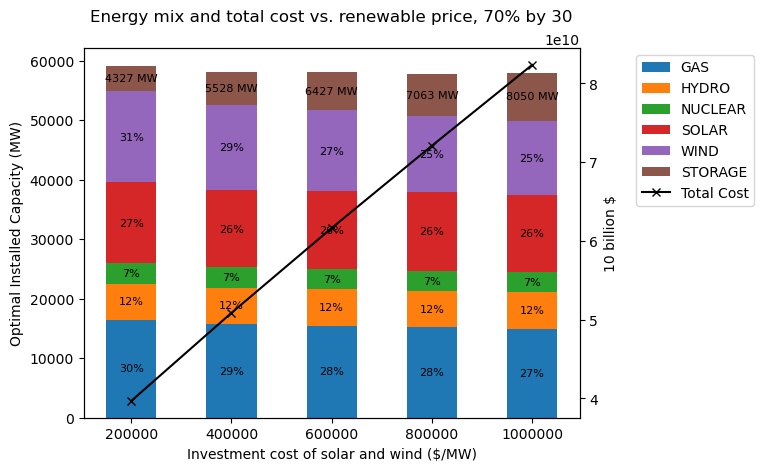

In [162]:
graph_stacked_bar(summary_df_sa_renewable,"Investment cost of solar and wind ($/MW)","Energy mix and total cost vs. renewable price, 70% by 30")

In [139]:
summary_df_sa_renewable_100_by_2040 = pd.DataFrame(columns=['GAS','HYDRO', 'NUCLEAR', 'SOLAR', 'WIND', 'STORAGE', 'TOTAL_COST'])

for i in range(len(df_names)):
    ampl = AMPL()
    solver = 'gurobi'
    ampl.set_option("solver", solver)
    ampl.read('final_proj_decarb.mod')

    # Define sets and parameters
    ampl.set_data(df_names[i], "G")
    ampl.set_data(cost_N_df, "N")
    ampl.set_data(storage_df, "S")
    ampl.param['nPeriods'] = len(demand_2040)
    ampl.param['power_viol_penalty'] = 10000
    ampl.param['demand'] = demand_2040
    ampl.param['availability'] = avail_2040
    ampl.param['decarb_percent'] = 1.0
    capacity_g = ampl.get_variable("capacity_g")
    capacity_g['NUCLEAR'].fix(3400) #3.4 GW of nuclear
    capacity_g['HYDRO'].fix(6085) #6.085 GW of hydro
    ampl.solve()

    # Get resource mix
    resource_mix_list = np.array(ampl.get_variable("capacity_g").get_values().to_pandas()).flatten()

    # Get storage capacity
    storage_mix_list = np.array(ampl.get_variable("capacity_s").get_values().to_pandas()).flatten()

    # Get total cost
    total_cost_list = np.array(ampl.get_objective("total_cost").get_values().to_pandas()).flatten()

    # Create DataFrame for current iteration
    iteration_df = pd.DataFrame({
        'GAS': resource_mix_list[0],
        'HYDRO': resource_mix_list[1],
        'NUCLEAR': resource_mix_list[2],
        'SOLAR': resource_mix_list[3],
        'WIND': resource_mix_list[4],
        'STORAGE': storage_mix_list[0],
        'TOTAL_COST': total_cost_list[0]
    }, index=[0])

    # Concatenate iteration DataFrame to summary DataFrame
    summary_df_sa_renewable_100_by_2040 = pd.concat([summary_df_sa_renewable_100_by_2040, iteration_df], ignore_index=True)

Gurobi 11.0.1:Gurobi 11.0.1: optimal solution; objective 7.083328443e+10
25248 simplex iterations
1 branching node
Gurobi 11.0.1:Gurobi 11.0.1: optimal solution; objective 1.217336758e+11
28466 simplex iterations
1 branching node
absmipgap=0.00393677, relmipgap=3.23392e-14
Gurobi 11.0.1:Gurobi 11.0.1: optimal solution; objective 1.669832646e+11
33757 simplex iterations
1 branching node
Gurobi 11.0.1:Gurobi 11.0.1: optimal solution; objective 2.081232416e+11
32875 simplex iterations
1 branching node
absmipgap=0.0067749, relmipgap=3.25524e-14
Gurobi 11.0.1:Gurobi 11.0.1: optimal solution; objective 2.449179952e+11
39949 simplex iterations
1 branching node


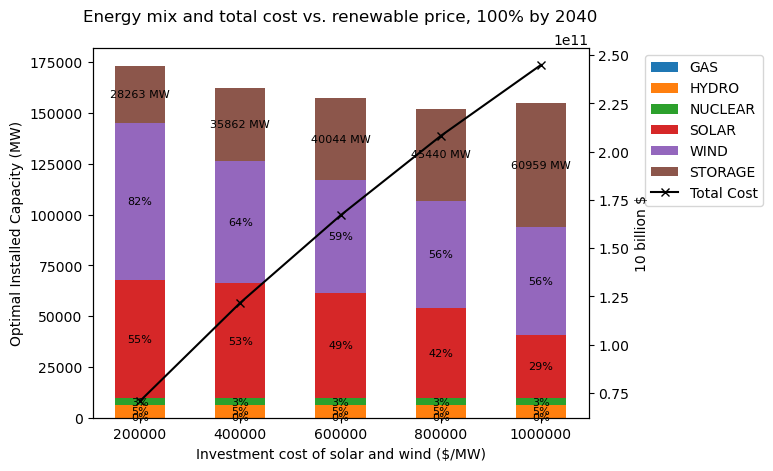

In [163]:
graph_stacked_bar(summary_df_sa_renewable_100_by_2040,"Investment cost of solar and wind ($/MW)","Energy mix and total cost vs. renewable price, 100% by 2040")

### 5. Catastrophe

In [489]:
big_noise = np.random.normal(loc=-0.15, scale=0.25, size=len(avail_df))

avail_2030_catastrophe = avail_2030.copy()
avail_2030_catastrophe['SOLAR']+=big_noise
avail_2030_catastrophe['WIND']+=big_noise
avail_2030_catastrophe['HYDRO']+=big_noise
avail_2030_catastrophe['SOLAR'] = np.clip(avail_2030_catastrophe['SOLAR'], 0, 1)
avail_2030_catastrophe['WIND'] = np.clip(avail_2030_catastrophe['WIND'], 0, 1)
avail_2030_catastrophe['HYDRO'] = np.clip(avail_2030_catastrophe['HYDRO'], 0, 1)

#### The code below iterates over different weather availability variances

In [496]:
summary_df = pd.DataFrame(columns=['GAS', 'HYDRO','NUCLEAR', 'SOLAR', 'WIND', 'STORAGE', 'TOTAL_COST'])

for variance in np.linspace(0.05, 0.25, 5):
        # Initialize AMPL instance
        ampl = AMPL()
        solver = 'gurobi'
        ampl.set_option("solver", solver)
        ampl.read('final_proj_decarb.mod')

        # Define sets and parameters
        ampl.set_data(gen_df, "G")
        ampl.set_data(cost_N_df, "N")
        ampl.set_data(storage_df, "S")
        ampl.param['nPeriods'] = len(demand_2030)
        ampl.param['power_viol_penalty'] = 10000
        ampl.param['demand'] = demand_2030

        # Generate catastrophe scenario
        big_noise = np.random.normal(loc=0, scale=variance, size=len(avail_df))
        avail_2030_catastrophe = avail_2030.copy()
        avail_2030_catastrophe['SOLAR']+=big_noise
        avail_2030_catastrophe['WIND']+=big_noise
        avail_2030_catastrophe['HYDRO']+=big_noise
        avail_2030_catastrophe['SOLAR'] = np.clip(avail_2030_catastrophe['SOLAR'], 0, 1)
        avail_2030_catastrophe['WIND'] = np.clip(avail_2030_catastrophe['WIND'], 0, 1)
        avail_2030_catastrophe['HYDRO'] = np.clip(avail_2030_catastrophe['HYDRO'], 0, 1)

        ampl.param['availability'] = avail_2030_catastrophe
        ampl.param['decarb_percent'] = 70 / 100
        capacity_g = ampl.get_variable("capacity_g")
        capacity_g['NUCLEAR'].fix(3400) #3.4 GW of nuclear
        capacity_g['HYDRO'].fix(6085) #6.085 GW of hydro

        # help it run faster
        ampl.set_option('gurobi_options', 'mipgap=0.05')

        ampl.solve()

        resource_mix_list = np.array(ampl.get_variable("capacity_g").get_values().to_pandas()).flatten()
        storage_mix_list = np.array(ampl.get_variable("capacity_s").get_values().to_pandas()).flatten()
        total_cost_list = np.array(ampl.get_objective("total_cost").get_values().to_pandas()).flatten()

        # Create DataFrame for current iteration
        iteration_df = pd.DataFrame({
            'GAS': resource_mix_list[0],
            'HYDRO': resource_mix_list[1],
            'NUCLEAR': resource_mix_list[2],
            'SOLAR': resource_mix_list[3],
            'WIND': resource_mix_list[4],
            'STORAGE': storage_mix_list[0],
            'TOTAL_COST': total_cost_list[0]
        }, index=[0])

        # Concatenate iteration DataFrame to summary DataFrame
        summary_df = pd.concat([summary_df, iteration_df], ignore_index=True)

Gurobi 11.0.1:Gurobi 11.0.1: optimal solution; objective 6.346316149e+10
57515 simplex iterations
1 branching node
absmipgap=0.0230331, relmipgap=3.62937e-13
Gurobi 11.0.1:Gurobi 11.0.1: optimal solution; objective 6.359055403e+10
54262 simplex iterations
1 branching node
absmipgap=0.00360107, relmipgap=5.66291e-14
Gurobi 11.0.1:Gurobi 11.0.1: optimal solution; objective 6.280328025e+10
55950 simplex iterations
1 branching node
absmipgap=0.0492935, relmipgap=7.84888e-13
Gurobi 11.0.1:Gurobi 11.0.1: optimal solution; objective 6.246243397e+10
56347 simplex iterations
1 branching node
absmipgap=0.0483856, relmipgap=7.74636e-13
Gurobi 11.0.1:Gurobi 11.0.1: optimal solution; objective 6.336075485e+10
50454 simplex iterations
1 branching node
absmipgap=0.063446, relmipgap=1.00135e-12


In [497]:
catastrophe_df=summary_df.copy()

In [ ]:
summary_df = pd.DataFrame(columns=['GAS', 'HYDRO','NUCLEAR', 'SOLAR', 'WIND', 'STORAGE', 'TOTAL_COST'])

for variance in np.linspace(0.05, 0.25, 5):
        # Initialize AMPL instance
        ampl = AMPL()
        solver = 'gurobi'
        ampl.set_option("solver", solver)
        ampl.read('final_proj_decarb.mod')

        # Define sets and parameters
        ampl.set_data(gen_df, "G")
        ampl.set_data(cost_N_df, "N")
        ampl.set_data(storage_df, "S")
        ampl.param['nPeriods'] = len(demand_2030)
        ampl.param['power_viol_penalty'] = 10000
        ampl.param['demand'] = demand_2030

        # Generate catastrophe scenario
        big_noise = np.random.normal(loc=0, scale=variance, size=len(avail_df))
        avail_2030_catastrophe = avail_2030.copy()
        avail_2030_catastrophe['SOLAR']+=big_noise
        avail_2030_catastrophe['WIND']+=big_noise
        avail_2030_catastrophe['HYDRO']+=big_noise
        avail_2030_catastrophe['SOLAR'] = np.clip(avail_2030_catastrophe['SOLAR'], 0, 1)
        avail_2030_catastrophe['WIND'] = np.clip(avail_2030_catastrophe['WIND'], 0, 1)
        avail_2030_catastrophe['HYDRO'] = np.clip(avail_2030_catastrophe['HYDRO'], 0, 1)

        ampl.param['availability'] = avail_2030_catastrophe
        ampl.param['decarb_percent'] = 70 / 100
        capacity_g = ampl.get_variable("capacity_g")
        capacity_g['NUCLEAR'].fix(3400) #3.4 GW of nuclear
        capacity_g['HYDRO'].fix(6085) #6.085 GW of hydro

        # help it run faster
        ampl.set_option('gurobi_options', 'mipgap=0.1')

        ampl.solve()

        resource_mix_list = np.array(ampl.get_variable("capacity_g").get_values().to_pandas()).flatten()
        storage_mix_list = np.array(ampl.get_variable("capacity_s").get_values().to_pandas()).flatten()
        total_cost_list = np.array(ampl.get_objective("total_cost").get_values().to_pandas()).flatten()

        # Create DataFrame for current iteration
        iteration_df = pd.DataFrame({
            'GAS': resource_mix_list[0],
            'HYDRO': resource_mix_list[1],
            'NUCLEAR': resource_mix_list[2],
            'SOLAR': resource_mix_list[3],
            'WIND': resource_mix_list[4],
            'STORAGE': storage_mix_list[0],
            'TOTAL_COST': total_cost_list[0]
        }, index=[0])

        # Concatenate iteration DataFrame to summary DataFrame
        summary_df = pd.concat([summary_df, iteration_df], ignore_index=True)

Gurobi 11.0.1:   mip:gap = 0.1
Gurobi 11.0.1: optimal solution; objective 6.390302321e+10
62777 simplex iterations
1 branching node
absmipgap=0.0358505, relmipgap=5.61015e-13
Gurobi 11.0.1:   mip:gap = 0.1
Gurobi 11.0.1: optimal solution; objective 6.335686412e+10
55708 simplex iterations
1 branching node
absmipgap=0.0291824, relmipgap=4.60604e-13
Gurobi 11.0.1:   mip:gap = 0.1
Gurobi 11.0.1: optimal solution; objective 6.308082293e+10
54469 simplex iterations
1 branching node
absmipgap=0.0184631, relmipgap=2.9269e-13
Gurobi 11.0.1:   mip:gap = 0.1
Gurobi 11.0.1: optimal solution; objective 6.38850283e+10
52620 simplex iterations
1 branching node
absmipgap=0.0635681, relmipgap=9.95039e-13
Gurobi 11.0.1: 

#### Iterate over 10 times, mean = -0.1

In [164]:
# Initialize a list to store the results of each run
summary_dfs = []

# Number of runs
n_runs = 10

for run in range(n_runs):
    summary_df = pd.DataFrame(columns=['GAS', 'HYDRO','NUCLEAR', 'SOLAR', 'WIND', 'STORAGE', 'TOTAL_COST'])

    for variance in np.linspace(0.05, 0.25, 5):
        # Initialize AMPL instance
        ampl = AMPL()
        solver = 'gurobi'
        ampl.set_option("solver", solver)
        ampl.read('final_proj_decarb.mod')

        # Define sets and parameters
        ampl.set_data(gen_df, "G")
        ampl.set_data(cost_N_df, "N")
        ampl.set_data(storage_df, "S")
        ampl.param['nPeriods'] = len(demand_2030)
        ampl.param['power_viol_penalty'] = 10000
        ampl.param['demand'] = demand_2030

        # Generate catastrophe scenario
        big_noise = np.random.normal(loc=-0.1, scale=variance, size=len(avail_df))
        avail_2030_catastrophe = avail_2030.copy()
        avail_2030_catastrophe['SOLAR']+=big_noise
        avail_2030_catastrophe['WIND']+=big_noise
        avail_2030_catastrophe['HYDRO']+=big_noise
        avail_2030_catastrophe['SOLAR'] = np.clip(avail_2030_catastrophe['SOLAR'], 0, 1)
        avail_2030_catastrophe['WIND'] = np.clip(avail_2030_catastrophe['WIND'], 0, 1)
        avail_2030_catastrophe['HYDRO'] = np.clip(avail_2030_catastrophe['HYDRO'], 0, 1)

        ampl.param['availability'] = avail_2030_catastrophe
        ampl.param['decarb_percent'] = 70 / 100
        capacity_g = ampl.get_variable("capacity_g")
        capacity_g['NUCLEAR'].fix(3400) #3.4 GW of nuclear
        capacity_g['HYDRO'].fix(6085) #6.085 GW of hydro

        # help it run faster
        ampl.set_option('gurobi_options', 'mipgap=0.1')

        ampl.solve()

        resource_mix_list = np.array(ampl.get_variable("capacity_g").get_values().to_pandas()).flatten()
        storage_mix_list = np.array(ampl.get_variable("capacity_s").get_values().to_pandas()).flatten()
        total_cost_list = np.array(ampl.get_objective("total_cost").get_values().to_pandas()).flatten()

        # Create DataFrame for current iteration
        iteration_df = pd.DataFrame({
            'GAS': resource_mix_list[0],
            'HYDRO': resource_mix_list[1],
            'NUCLEAR': resource_mix_list[2],
            'SOLAR': resource_mix_list[3],
            'WIND': resource_mix_list[4],
            'STORAGE': storage_mix_list[0],
            'TOTAL_COST': total_cost_list[0]
        }, index=[0])

        # Concatenate iteration DataFrame to summary DataFrame
        summary_df = pd.concat([summary_df, iteration_df], ignore_index=True)

    # Append the summary DataFrame of this run to the list
    summary_dfs.append(summary_df)

# Concatenate all the summary DataFrames
all_runs_df = pd.concat(summary_dfs)

# Calculate the average for each column
average_df = all_runs_df.groupby(all_runs_df.index).mean()

all_runs_df.to_csv('./catastrophe_10_runs_mean_neg01.csv')

Gurobi 11.0.1:   mip:gap = 0.1
Gurobi 11.0.1: optimal solution; objective 7.265710043e+10
50188 simplex iterations
1 branching node
absmipgap=0.0100555, relmipgap=1.38397e-13
Gurobi 11.0.1:   mip:gap = 0.1
Gurobi 11.0.1: optimal solution; objective 7.196941211e+10
52170 simplex iterations
1 branching node
absmipgap=0.0124969, relmipgap=1.73642e-13
Gurobi 11.0.1:   mip:gap = 0.1
Gurobi 11.0.1: optimal solution; objective 7.133899088e+10
60217 simplex iterations
1 branching node
absmipgap=0.0472107, relmipgap=6.6178e-13
Gurobi 11.0.1:   mip:gap = 0.1
Gurobi 11.0.1: optimal solution; objective 7.076766546e+10
56622 simplex iterations
1 branching node
absmipgap=0.00584412, relmipgap=8.25817e-14
Gurobi 11.0.1:   mip:gap = 0.1
Gurobi 11.0.1: optimal solution; objective 6.946483122e+10
49620 simplex iterations
1 branching node
absmipgap=0.0401154, relmipgap=5.77492e-13
Gurobi 11.0.1:   mip:gap = 0.1
Gurobi 11.0.1: optimal solution; objective 7.236780336e+10
65057 simplex iterations
1 branchin

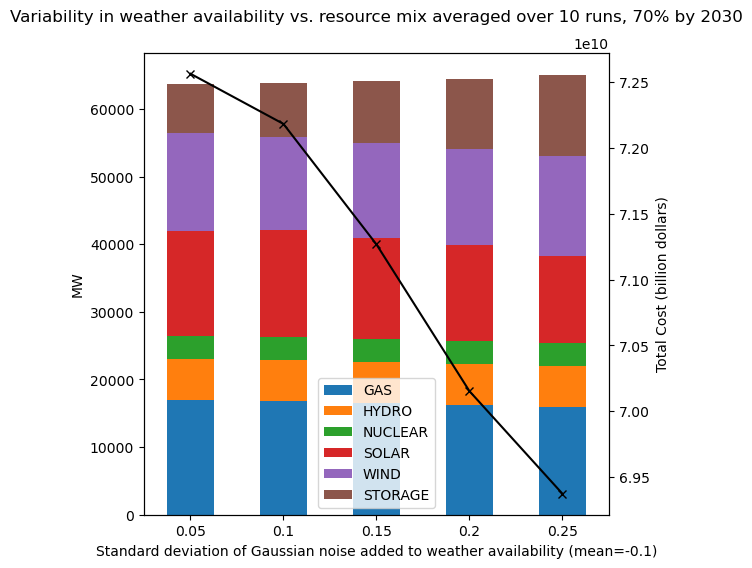

In [201]:
catastrophe_10_runs_mean_neg01 = pd.read_csv('./catastrophe_10_runs_mean_neg01.csv')
avg_df = catastrophe_10_runs_mean_neg01.groupby(catastrophe_10_runs_mean_neg01['Unnamed: 0']).mean()
catastrophe_df_reset = avg_df.reset_index()
ax = catastrophe_df_reset[['GAS', 'HYDRO','NUCLEAR', 'SOLAR', 'WIND', 'STORAGE']].plot(kind='bar', stacked=True, figsize=(6, 6))
catastrophe_df_reset['TOTAL_COST'].plot(kind='line', marker='x', color='k', secondary_y=True,ax=ax)

ax.set_xlabel('Standard deviation of Gaussian noise added to weather availability (mean=-0.1)')
ax.set_ylabel('MW')
ax.right_ax.set_ylabel('Total Cost (billion dollars)')

plt.title('Variability in weather availability vs. resource mix averaged over 10 runs, 70% by 2030',y=1.05)
variance_range = [str(i/20) for i in range(1,6)]
plt.xticks(range(5), variance_range)
plt.show()

#### Iterate over 10 times, mean = 0

In [546]:
# Initialize a list to store the results of each run
summary_dfs = []

# Number of runs
n_runs = 10

for run in range(n_runs):
    summary_df = pd.DataFrame(columns=['GAS', 'HYDRO','NUCLEAR', 'SOLAR', 'WIND', 'STORAGE', 'TOTAL_COST'])

    for variance in np.linspace(0.05, 0.25, 5):
        # Initialize AMPL instance
        ampl = AMPL()
        solver = 'gurobi'
        ampl.set_option("solver", solver)
        ampl.read('final_proj_decarb.mod')

        # Define sets and parameters
        ampl.set_data(gen_df, "G")
        ampl.set_data(cost_N_df, "N")
        ampl.set_data(storage_df, "S")
        ampl.param['nPeriods'] = len(demand_2030)
        ampl.param['power_viol_penalty'] = 10000
        ampl.param['demand'] = demand_2030

        # Generate catastrophe scenario
        big_noise = np.random.normal(loc=0, scale=variance, size=len(avail_df))
        avail_2030_catastrophe = avail_2030.copy()
        avail_2030_catastrophe['SOLAR']+=big_noise
        avail_2030_catastrophe['WIND']+=big_noise
        avail_2030_catastrophe['HYDRO']+=big_noise
        avail_2030_catastrophe['SOLAR'] = np.clip(avail_2030_catastrophe['SOLAR'], 0, 1)
        avail_2030_catastrophe['WIND'] = np.clip(avail_2030_catastrophe['WIND'], 0, 1)
        avail_2030_catastrophe['HYDRO'] = np.clip(avail_2030_catastrophe['HYDRO'], 0, 1)

        ampl.param['availability'] = avail_2030_catastrophe
        ampl.param['decarb_percent'] = 70 / 100
        capacity_g = ampl.get_variable("capacity_g")
        capacity_g['NUCLEAR'].fix(3400) #3.4 GW of nuclear
        capacity_g['HYDRO'].fix(6085) #6.085 GW of hydro

        # help it run faster
        ampl.set_option('gurobi_options', 'mipgap=0.1')

        ampl.solve()

        resource_mix_list = np.array(ampl.get_variable("capacity_g").get_values().to_pandas()).flatten()
        storage_mix_list = np.array(ampl.get_variable("capacity_s").get_values().to_pandas()).flatten()
        total_cost_list = np.array(ampl.get_objective("total_cost").get_values().to_pandas()).flatten()

        # Create DataFrame for current iteration
        iteration_df = pd.DataFrame({
            'GAS': resource_mix_list[0],
            'HYDRO': resource_mix_list[1],
            'NUCLEAR': resource_mix_list[2],
            'SOLAR': resource_mix_list[3],
            'WIND': resource_mix_list[4],
            'STORAGE': storage_mix_list[0],
            'TOTAL_COST': total_cost_list[0]
        }, index=[0])

        # Concatenate iteration DataFrame to summary DataFrame
        summary_df = pd.concat([summary_df, iteration_df], ignore_index=True)

    # Append the summary DataFrame of this run to the list
    summary_dfs.append(summary_df)

# Concatenate all the summary DataFrames
all_runs_df = pd.concat(summary_dfs)

# Calculate the average for each column
average_df = all_runs_df.groupby(all_runs_df.index).mean()

Gurobi 11.0.1:   mip:gap = 0.1
Gurobi 11.0.1: optimal solution; objective 6.390718901e+10
60492 simplex iterations
1 branching node
absmipgap=0.00934601, relmipgap=1.46243e-13
Gurobi 11.0.1:   mip:gap = 0.1
Gurobi 11.0.1: optimal solution; objective 6.355368073e+10
54726 simplex iterations
1 branching node
absmipgap=0.0323715, relmipgap=5.09357e-13
Gurobi 11.0.1:   mip:gap = 0.1
Gurobi 11.0.1: optimal solution; objective 6.301630577e+10
56070 simplex iterations
1 branching node
absmipgap=0.0190887, relmipgap=3.02918e-13
Gurobi 11.0.1:   mip:gap = 0.1
Gurobi 11.0.1: optimal solution; objective 6.163597435e+10
52908 simplex iterations
1 branching node
absmipgap=0.0413208, relmipgap=6.70401e-13
Gurobi 11.0.1:   mip:gap = 0.1
Gurobi 11.0.1: optimal solution; objective 6.244162495e+10
51553 simplex iterations
1 branching node
absmipgap=0.0770493, relmipgap=1.23394e-12
Gurobi 11.0.1:   mip:gap = 0.1
Gurobi 11.0.1: optimal solution; objective 6.391916516e+10
57818 simplex iterations
1 branchi

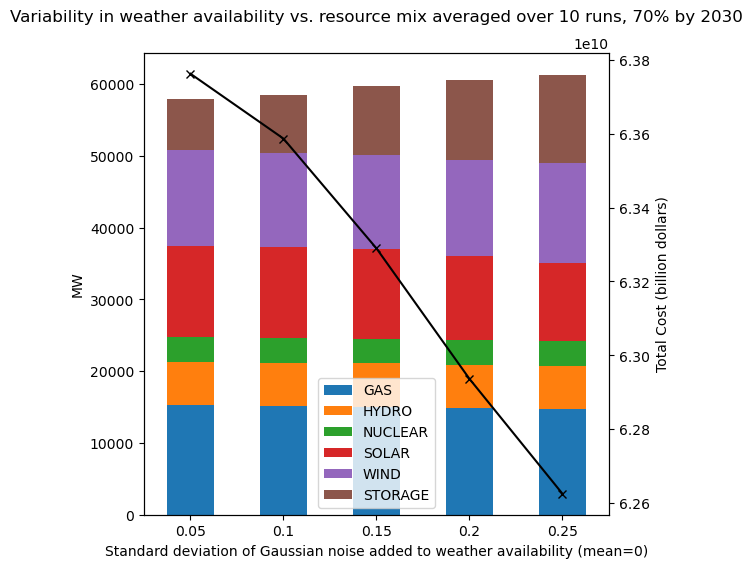

In [202]:
catastrophe_10_runs_mean0 = pd.read_csv('./catastrophe_10_runs_mean0')
avg_df = catastrophe_10_runs_mean0.groupby(catastrophe_10_runs_mean0['Unnamed: 0']).mean()
catastrophe_df_reset = avg_df.reset_index()
ax = catastrophe_df_reset[['GAS', 'HYDRO','NUCLEAR', 'SOLAR', 'WIND', 'STORAGE']].plot(kind='bar', stacked=True, figsize=(6, 6))
catastrophe_df_reset['TOTAL_COST'].plot(kind='line', marker='x', color='k', secondary_y=True,ax=ax)

ax.set_xlabel('Standard deviation of Gaussian noise added to weather availability (mean=0)')
ax.set_ylabel('MW')
ax.right_ax.set_ylabel('Total Cost (billion dollars)')

plt.title('Variability in weather availability vs. resource mix averaged over 10 runs, 70% by 2030',y=1.05)
variance_range = [str(i/20) for i in range(1,6)]
plt.xticks(range(5), variance_range)
plt.show()

# Unused code

In [515]:
summary_df = pd.DataFrame(columns=['GAS', 'HYDRO','NUCLEAR', 'SOLAR', 'WIND', 'STORAGE', 'TOTAL_COST'])

for mean in np.arange(-0.5,0,0.1):
        # Initialize AMPL instance
        ampl = AMPL()
        solver = 'gurobi'
        ampl.set_option("solver", solver)
        ampl.read('final_proj_decarb.mod')

        # Define sets and parameters
        ampl.set_data(gen_df, "G")
        ampl.set_data(cost_N_df, "N")
        ampl.set_data(storage_df, "S")
        ampl.param['nPeriods'] = len(demand_2030)
        ampl.param['power_viol_penalty'] = 10000
        ampl.param['demand'] = demand_2030

        # Generate catastrophe scenario
        big_noise = np.random.normal(loc=mean, scale=0.05, size=len(avail_df))
        avail_2030_catastrophe = avail_2030.copy()
        avail_2030_catastrophe['SOLAR']+=big_noise
        avail_2030_catastrophe['WIND']+=big_noise
        avail_2030_catastrophe['HYDRO']+=big_noise
        avail_2030_catastrophe['SOLAR'] = np.clip(avail_2030_catastrophe['SOLAR'], 0, 1)
        avail_2030_catastrophe['WIND'] = np.clip(avail_2030_catastrophe['WIND'], 0, 1)
        avail_2030_catastrophe['HYDRO'] = np.clip(avail_2030_catastrophe['HYDRO'], 0, 1)

        ampl.param['availability'] = avail_2030_catastrophe
        ampl.param['decarb_percent'] = 70 / 100
        capacity_g = ampl.get_variable("capacity_g")
        capacity_g['NUCLEAR'].fix(3400) #3.4 GW of nuclear
        capacity_g['HYDRO'].fix(6085) #6.085 GW of hydro
        ampl.solve()

        resource_mix_list = np.array(ampl.get_variable("capacity_g").get_values().to_pandas()).flatten()
        storage_mix_list = np.array(ampl.get_variable("capacity_s").get_values().to_pandas()).flatten()
        total_cost_list = np.array(ampl.get_objective("total_cost").get_values().to_pandas()).flatten()

        # Create DataFrame for current iteration
        iteration_df = pd.DataFrame({
            'GAS': resource_mix_list[0],
            'HYDRO': resource_mix_list[1],
            'NUCLEAR': resource_mix_list[2],
            'SOLAR': resource_mix_list[3],
            'WIND': resource_mix_list[4],
            'STORAGE': storage_mix_list[0],
            'TOTAL_COST': total_cost_list[0]
        }, index=[0])

        # Concatenate iteration DataFrame to summary DataFrame
        summary_df = pd.concat([summary_df, iteration_df], ignore_index=True)

Gurobi 11.0.1:Gurobi 11.0.1: optimal solution; objective 9.424054097e+10
44638 simplex iterations
1 branching node
absmipgap=0.00683594, relmipgap=7.25371e-14
Gurobi 11.0.1:Gurobi 11.0.1: optimal solution; objective 9.107903031e+10
35748 simplex iterations
1 branching node
absmipgap=0.00630188, relmipgap=6.91913e-14
Gurobi 11.0.1:Gurobi 11.0.1: optimal solution; objective 8.659316515e+10
69946 simplex iterations
1 branching node
absmipgap=0.00248718, relmipgap=2.87226e-14
Gurobi 11.0.1:Gurobi 11.0.1: optimal solution; objective 8.035065113e+10
51625 simplex iterations
1 branching node
absmipgap=0.00228882, relmipgap=2.84854e-14
Gurobi 11.0.1:Gurobi 11.0.1: optimal solution; objective 7.276816547e+10
53849 simplex iterations
1 branching node
absmipgap=0.00454712, relmipgap=6.24878e-14


In [516]:
catastrophe_df_mean=summary_df.copy()

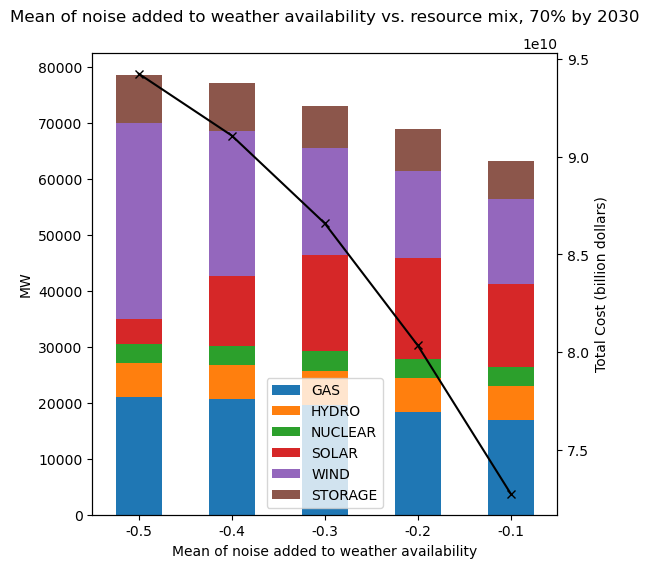

In [541]:
catastrophe_df_mean_reset = catastrophe_df_mean.reset_index()
ax = catastrophe_df_mean_reset[['GAS', 'HYDRO','NUCLEAR', 'SOLAR', 'WIND', 'STORAGE']].plot(kind='bar', stacked=True, figsize=(6, 6))
catastrophe_df_mean_reset['TOTAL_COST'].plot(kind='line', marker='x', color='k', secondary_y=True,ax=ax)

ax.set_xlabel('Mean of noise added to weather availability')
ax.set_ylabel('MW')
ax.right_ax.set_ylabel('Total Cost (billion dollars)')

plt.title('Mean of noise added to weather availability vs. resource mix, 70% by 2030',y=1.05)
variance_range = [str(-i/10) for i in range(5,0,-1)]
plt.xticks(range(5), variance_range)
plt.show()

In [203]:
n_years = 20

demand_repeated = np.tile(demand_df.values, (n_years, 1))
demand_n_year = pd.DataFrame(demand_repeated, columns=['demand'])
growth_rates = np.repeat([1.0005] * 10 + [1.0129] * 10,8760) #([1.0005] * 10 + [1.0129] * 10 + [1.089] * 10,8760)
demand_n_year['growth_rate'] = growth_rates

demand_n_year['updated_demand'] = demand_n_year['demand']
for i in range(1, n_years):
    demand_n_year.loc[8760 * i:, 'updated_demand'] = (demand_n_year.loc[8760 * (i - 1):, 'updated_demand'] 
                                                      * demand_n_year.loc[8760 * i:, 'growth_rate'])
demand_n_year.index = demand_n_year.index +1
demand_n_year.drop(['demand', 'growth_rate'], axis=1, inplace=True)
demand_n_year.rename(columns={'updated_demand': 'demand'}, inplace=True)

demand_n_year.tail()

,demand
175196,2471.544619
175197,2478.050933
175198,2537.283907
175199,2613.190905
175200,2568.629032
